/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


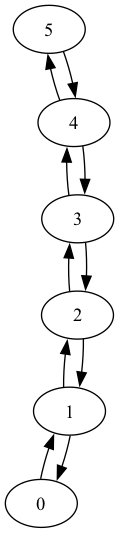

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

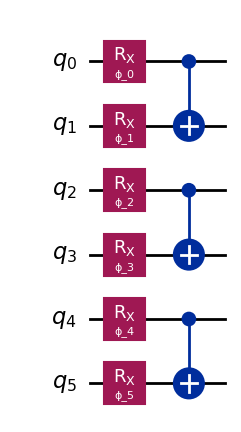

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


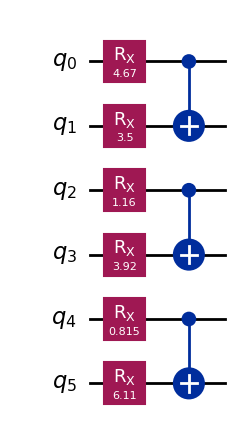

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

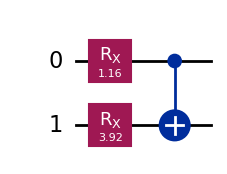

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

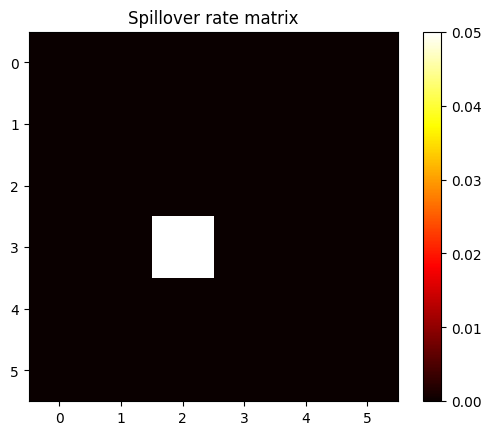

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

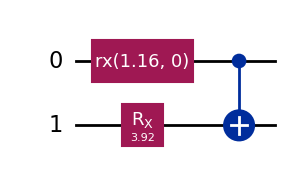

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j],
       [0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.9246618340416872]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '6d593e56a2824886b8576f7433602cd0',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99519043+0.j       , 0.        -0.0979592j],
              [0.        -0.0979592j, 0.99519043+0.j       ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x151710710>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '6d593e56a2824886b8576f7433602cd0',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99519043+0.j       , 0.        -0.0979592j],
              [0.        -0.0979592j, 0.99519043+0.j       ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


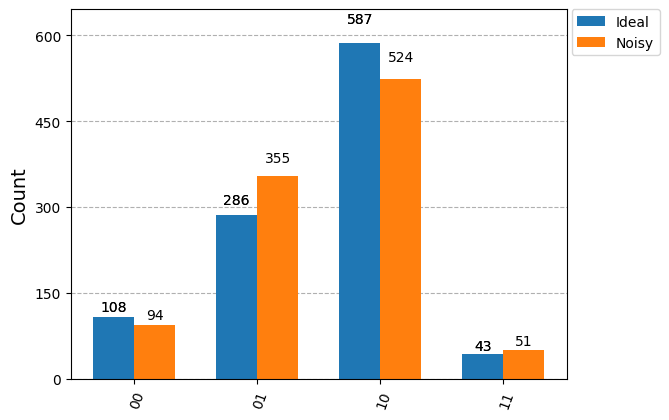

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9923231967419589

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -np.pi/2,
        np.pi/2,
        q_reg[0],
    )
    my_qc.u(
        0.,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         *new_params[:3],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [56]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.25, high=0.25, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[5,],
        n_shots=100,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [57]:
# Constructing single angle spillover env

from single_angle_spillover_env import OneParamAngleSpilloverEnv

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [58]:
rescaled_q_env = RescaleAndClipAction(one_env, min_action=-1., max_action=1.)

In [59]:
_, _ = one_env.reset(debug_obs=np.array([np.pi]))

Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]


In [60]:
action = np.zeros((1, 7))
action[0, 0] = -0.05 * np.pi

action

array([[-0.15707963,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 13
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 0.9999999999999998 Std: 0.0
Number of repetitions: 17
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 0.9999999999999998 Std: 0.0
Number of repetitions: 21
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 0.9999999999999998 Std: 0.0
Number of repetitions: 25
Starting simulation benchmark...

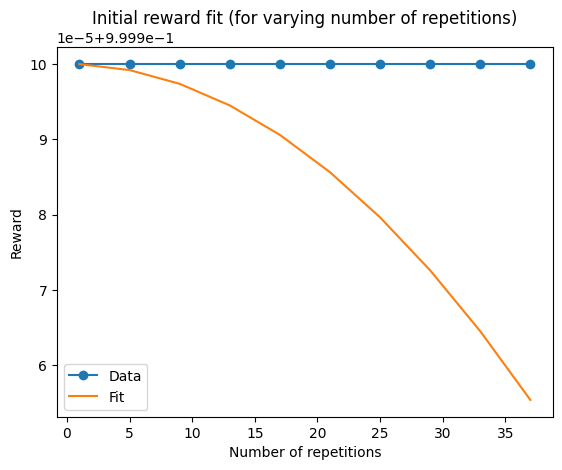

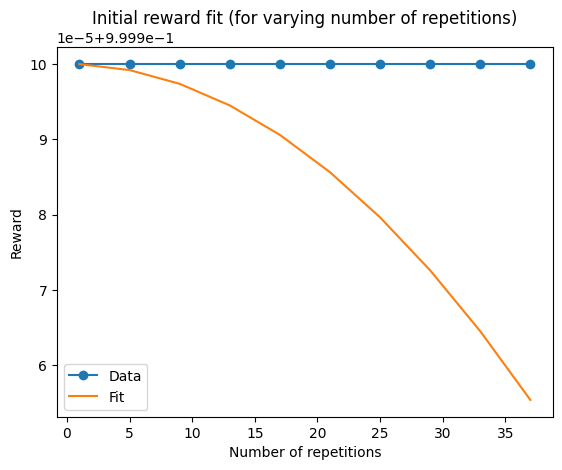

In [27]:
one_env.initial_reward_fit(
    action,
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 40, 4),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    # fit_p0=[0.05 * np.pi, 0.]
)

In [28]:
baseline_reward = []

one_env.clear_history()
for set_obs in one_env.discrete_obs_vals_angles:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = one_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((one_env.batch_size,) + one_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = one_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {one_env.discrete_reward_history}")

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
obs: [-1.]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]
discrete reward history: [[6. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996916144962891
Reward (avg): 0.9959985898020056 Std: 0.0
obs: [-0.5]
reward: [2.39778693 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693
 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693
 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693
 2.39778693 2.39778693 2.39778693 2.397786

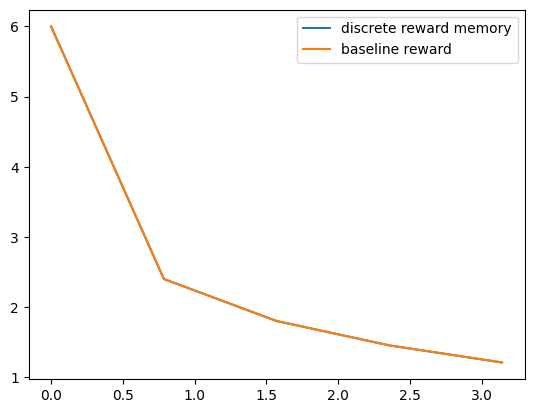

In [29]:
plt.plot(one_env.discrete_obs_vals_angles, one_env.discrete_reward_history[0], label='discrete reward memory')
plt.plot(one_env.discrete_obs_vals_angles, baseline_reward, label='baseline reward')
plt.legend()
plt.show()

In [61]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(one_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [62]:
# Testing the optimal policy in advance

single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=1000,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [63]:
# Testing fidelity of agents

import copy
import torch

rewards = []

# action_test = copy.deepcopy(actions)
o_vals = one_env.discrete_obs_vals_angles
ana_sum = -o_vals * 0.05 # gamma value
ana_scaled = ana_sum / 0.25 # env action space bounds
# ana_scaled = np.zeros_like(ana_sum)

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals_angles):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = ppo_agent.env.unwrapped.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    # act = action_test[i]
    act = np.zeros(7)
    act[0] = ana_scaled[i]
    act[1] = 0.
    act[2] = 0.
    act[3] = 0. # ana_scaled[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    
    print(f"action: {act}")
    batch_action = np.tile(act, (ppo_agent.env.unwrapped.batch_size, 1))
    obs, reward, terminated, truncated, info = ppo_agent.env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
action: [-0.  0.  0.  0.  0.  0.  0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
obs: [-1.]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
action: [-0.15707963  0.          0.          0.          0.          0.
  0.        ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999993 Std: 0.0
obs: [-0.5]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]
Sampled angles:  [0.         0.         0.         1.57079633 0.         0.        ]
Environment Observation: [0.]
action: [-0.31415927  0.          0.          0.          0.          0.
  0.        ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 0.9999999999999997 Std: 0.0
obs: [0.]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]
Sampled angles:  [0.         0.         0.         2.35619449 0.         0.        ]
Environment Observation: [0.5]
action: [-0.4712389  0.         0.         0.         0.         0.
  0.       ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 1.0000000000000007 Std: 0.0
obs: [0.5]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
action: [-0.62831853  0.          0.          0.          0.          0.
  0.        ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
obs: [1.]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]


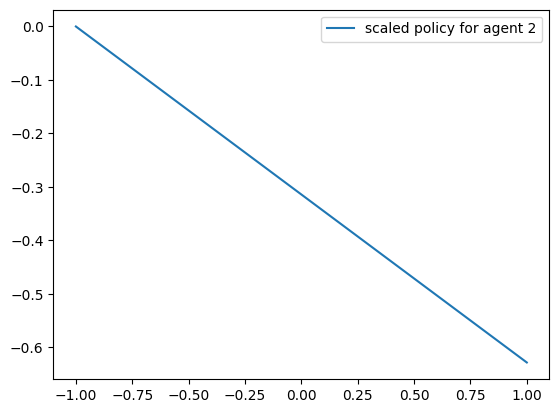

In [64]:
# plt.plot(o_vals, ana_sum, label='optimal policy')
# plt.plot(o_vals, ana_scaled, label='scaled policy for agent')
plt.plot((o_vals / np.pi - 0.5) * 2, ana_scaled, label='scaled policy for agent 2')
plt.legend()
plt.show()

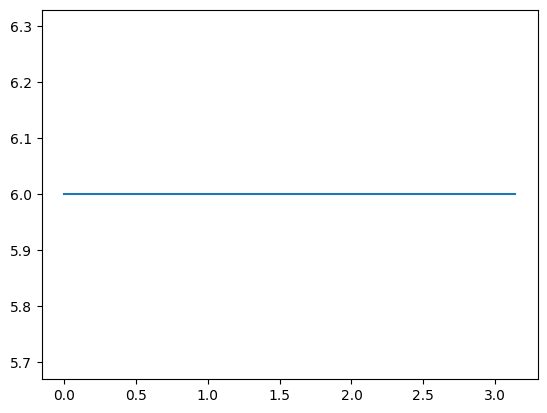

In [65]:
plt.plot(o_vals, rewards)
plt.show()

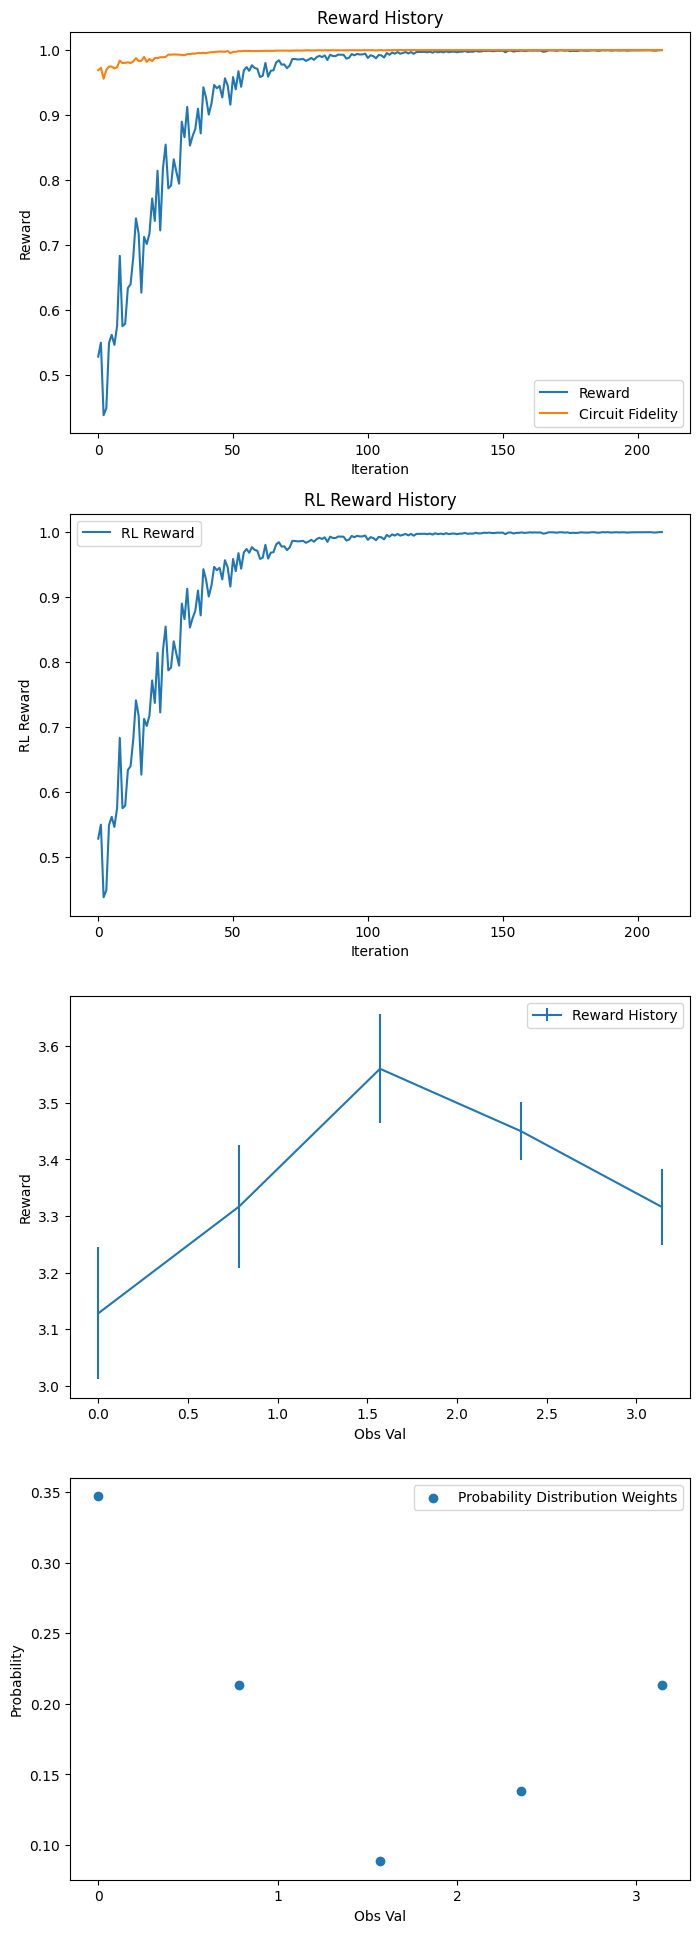

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999725048403205
Reward (avg): 0.9996562157208271 Std: 0.00032616305555477137
obs: [-0.5]
reward: [2.83012374 3.83926854 4.33109897 3.33844707 3.56736697 3.42203837
 3.6410178  4.35976708 4.22322131 3.53210311 3.17121959 3.56210046
 3.26447653 4.09292116 4.37074656 3.14101374 3.80635682 3.89101751
 3.66238035 4.05823743 3.54417983 3.15551623 3.6790916  3.69365721
 3.01411347 4.04967887 3.12501104 4.24113961 3.43881166 3.10286898
 3.86833363 3.92167659]
Mean Action: [-0.16459829 -0.04061969  0.03425958  0.00183142 -0.01493748 -0.00372341
  0.00146518]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
SPS: 38
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999674052358054
Reward (avg): 0.9994796718932739 Std: 0.0002309766307147721
obs: [-1.]
reward: [3.2747456  3.21784388 2.97442888 3.79385209 3.24821232 3.36308869
 3.13745561 3.45906036 3.36162715 3.08871539 3.5915507  3.57334113
 3.2796505  3.07119671 3.25104609 2.94826168 3.65663476 3.48968552
 3.43852658 3.3944838  3.32876239 3.53088758 3.22796668 3.24692797
 3.29934816 3.27578019 3.48814204 3.43805958 3.20970542 3.02734729
 3.33349534 3.38897173]
Mean Action: [-0.0305585  -0.04370844  0.03637781  0.00675226 -0.00940532 -0.00695699
  0.0041148 ]
Sampled angles:  [0.         0.         0.         2.35619449 0.         0.        ]
Environment Observation: [0.5]
SPS: 38
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999706538913233
Reward (avg): 0.9996787732726273 Std: 0.00020543476225929775
obs: [0.5]
reward: [3.17624787 3.64140468 3.99761101 3.63012184 3.77271999 3.60522068
 3.58564014 3.42245965 3.27376556 3.31370203 3.28701516 3.85724524
 3.76920432 3.69343592 3.43830494 3.24470712 4.33701035 3.65572549
 3.18775711 3.67691626 4.08013168 3.0210121  3.52520325 4.06798228
 3.34049909 3.39605843 3.65033218 3.69911798 3.61912944 3.88496847
 3.2319408  3.63803104]
Mean Action: [-0.47573295 -0.02831205  0.02974921 -0.00393108 -0.00900469 -0.01002086
  0.00071243]


KeyboardInterrupt: 

In [66]:
ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [67]:
NUM_EVAL = 15
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999709901440696
Reward (avg): 0.9995224891530727 Std: 0.0002162715693843647
obs: [-1.]
reward: [4.11475908 3.24103355 3.33209565 3.23538716 3.28304159 3.48824347
 3.77439515 3.4560425  3.30582507 3.60738295 3.1555135  3.37095765
 3.1758235  3.30754531 3.40823161 3.20728467 3.59293646 3.34303173
 3.23170571 3.46532931 3.1679181  3.29995494 3.42044438 3.37015374
 3.36850422 3.44602745 3.67775783 3.2265357  3.20098362 3.55741221
 3.09349873 2.90175662]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.99996833163257
Reward (avg): 0.9995072742600752 Std: 0.0002909407905813731
obs: [1.]
reward: [3.12981102 2.82100199 3.73301227 3.41215023 3.69241351 3.20390654
 3.10819369 3.31518712 3.26116895 3.34500869 3.27920001 3.70319398
 3.41898391 4.03162427 3.65839876 3.14623841 2.97975421 3.46596153
 3.28644175 3.58483239 3.83021614 3.18688444 3.1191833  3.68156838
 3.44863504 3.34094212 3.46889612 3.26673821 3.59777782 3.45391684
 3.1421518  3.11398561]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999692438963051
Reward (avg): 0.9995011998396157 Std: 0.0003145397757958532
obs: [-1.]
reward: [3.77069383 2.99442766 3.81717601 3.34683954 3.24100251 3.35282845
 3.5410183  3.38515361 3.1751008  3.85451624 3.60890724 3.88690351
 3.74573394 3.28316285 3.51730551 3.26288069 3.03189973 3.79647208
 3.55073575 3.14865325 3.00196167 3.01854089 3.07084195 3.40917953
 3.14003113 3.53910895 3.44390717 3.43016251 3.55535181 2.83265555
 3.34759709 3.29293358]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999975661916712
Reward (avg): 0.9997440042379961 Std: 0.00016420540036554947
obs: [-0.5]
reward: [3.57255032 4.0739736  3.2398784  4.27936023 3.45045475 3.71832325
 3.37368169 3.7169392  3.4946738  3.5536005  3.62022817 3.55064696
 3.42135848 3.96691941 3.55484631 3.75004985 3.4608134  3.6107533
 3.4086663  3.69424688 3.24695664 3.79357502 3.61490659 3.5962714
 4.81823755 4.11850743 4.02049313 3.55083042 3.56315655 4.51368873
 3.12130006 4.28587821]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999657254463551
Reward (avg): 0.9994371029104515 Std: 0.0002733911320860389
obs: [-1.]
reward: [3.20485396 3.17055605 3.05705554 3.2816603  3.33912008 3.25082852
 3.31508542 3.60127837 3.27355868 3.23899117 3.22431933 3.30733107
 3.47857336 3.45785898 3.48922719 2.95714519 3.09279044 3.23775166
 3.51243142 3.24671118 3.31020341 2.95480471 2.93384927 3.45464253
 3.41774965 3.75207547 3.11576581 3.73372648 3.10061521 2.97087944
 3.60807786 3.58667831]
Sampled angles:  [0.         0.         0.         2.35619449 0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999753711805577
Reward (avg): 0.9997114811314388 Std: 0.00018965393484249882
obs: [0.5]
reward: [4.00063091 3.70087478 3.28637931 3.48877913 3.52862384 4.24774196
 3.89768823 3.60046759 3.63510547 3.69425886 3.40753378 3.90685975
 2.99473518 3.38079523 3.88810676 3.72745037 3.46577328 3.48522541
 3.59871885 4.07271795 3.40066941 3.3418263  3.44517179 3.43274802
 3.49554828 3.91987819 3.75831954 4.19044496 3.20427022 3.62976221
 3.38207196 3.8912382 ]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999728776536685
Reward (avg): 0.9996956827053807 Std: 0.00016485654346520988
obs: [-0.5]
reward: [3.3556141  3.29370543 3.31499722 3.94604115 3.7858289  3.45853327
 3.62277634 3.56901977 4.07809787 3.15134983 3.74165615 3.50537825
 3.3826105  3.90738612 3.56032839 3.36224351 3.31407648 3.51484048
 3.26631082 3.7089395  3.28939254 3.69538595 3.86503543 3.59694461
 3.75758435 3.52102118 3.33773043 3.44729571 4.20439125 4.27177404
 3.3070547  3.97115448]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999703023686386
Reward (avg): 0.9995058167053965 Std: 0.0002840266006007307
obs: [1.]
reward: [3.10779423 3.52713428 2.96864555 4.25717975 3.00559189 3.39316971
 3.46254297 3.41595795 3.60903139 3.33418864 3.27084993 3.59652858
 3.46997776 3.56374242 3.83077072 3.16147913 3.17422729 3.41900312
 3.3621396  3.75404699 3.7379241  2.95733609 2.97246094 3.54650522
 3.26244787 3.27504833 3.29306083 3.35568586 3.26274803 3.01289748
 3.62907607 3.33452012]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999724944861206
Reward (avg): 0.9995647542417285 Std: 0.00025515484676375216
obs: [1.]
reward: [3.32948759 2.93648292 3.43956323 3.32860933 3.45169083 3.18890128
 3.56403489 3.5990954  3.46309165 3.57333457 3.15463765 3.21771316
 3.5109951  3.68452835 3.09454301 2.93152046 3.67859331 3.4902119
 3.77191621 3.71950533 3.05465586 3.52015905 3.32987408 3.65070137
 3.48764212 3.35633247 3.73917895 3.48096266 3.41064637 3.46121062
 3.43244716 3.41291699]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999753664021004
Reward (avg): 0.9997351065702553 Std: 0.00016770169756756908
obs: [-0.5]
reward: [3.61167894 3.91235362 3.67731187 3.92201498 3.61907944 3.85337582
 3.26343792 3.69716212 3.39683561 3.67924192 3.5344136  4.3083566
 3.55588538 4.32695214 3.9756165  3.06942585 3.4858342  3.39859395
 4.49948971 3.9566777  3.60494866 3.43310652 3.44117414 3.80715278
 3.59139502 3.56718722 3.38353245 3.48023504 3.6267182  3.75520045
 3.78470866 3.24620194]
Sampled angles:  [0.         0.         0.         2.35619449 0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999792139814925
Reward (avg): 0.9997566566652951 Std: 0.00017637783696724464
obs: [0.5]
reward: [3.85476288 3.39650007 3.19071426 4.05435396 3.59546534 3.08880731
 3.74325297 3.85349588 4.23982856 3.40885631 3.63180384 3.81603045
 3.55335188 3.35825045 3.52735539 3.95520201 3.65885332 4.36709904
 4.07336185 3.32821479 4.03775125 3.77906748 3.54846179 3.83340337
 3.5704479  3.30304029 4.02736502 3.99786956 4.41159047 3.69461226
 3.6400847  3.63989486]
Sampled angles:  [0.         0.         0.         1.57079633 0.         0.        ]
Environment Observation: [0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999744465058953
Reward (avg): 0.9997340238224366 Std: 0.00017577735166742555
obs: [0.]
reward: [4.05282008 3.18841731 4.00403088 3.99319704 4.27821434 3.60673435
 3.67052282 4.36277048 3.8309059  3.74516254 3.8440945  3.28229581
 3.55611868 3.36122514 3.76506845 3.6204565  3.60263263 3.86015223
 3.92117026 3.46124349 4.03875209 3.38086407 3.71841932 3.70062209
 3.69167934 3.23239028 3.45831655 3.15593466 3.25298637 3.72164294
 3.73168559 3.42096296]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999716943973453
Reward (avg): 0.9995329132468009 Std: 0.00020549509740372464
obs: [-1.]
reward: [3.0272269  3.68429939 3.23964195 3.24604563 3.58103866 3.44154451
 3.08572102 3.39498146 3.2760802  3.57938803 3.50962126 3.36594928
 3.4666985  3.21553774 3.20809485 3.70311599 3.26844244 3.37920718
 3.34153209 3.43701233 3.03106516 3.42196116 3.30311063 3.41854964
 3.37292919 3.59191687 3.35763144 3.1696208  3.54023421 3.55170185
 3.03706947 3.58422957]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999705536511617
Reward (avg): 0.999688284418577 Std: 0.00022663169930031091
obs: [-0.5]
reward: [3.09585168 3.62928342 4.45550267 3.49403525 3.46884016 3.5749826
 3.34208212 3.78698852 3.50636524 3.14466587 3.49971893 2.95521928
 3.87274575 4.08445718 3.58630387 4.72978237 3.7218545  3.45745724
 3.68584232 3.48208198 4.01093069 3.24298846 3.79031767 3.34024876
 3.66242469 3.48219965 3.46044587 3.51158581 3.66983711 3.38940468
 4.39430748 3.73211093]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999967749156123
Reward (avg): 0.9994710979027382 Std: 0.0003354555395093465
obs: [1.]
reward: [3.82099424 3.47901811 3.48661295 3.31426354 3.16609012 4.06049223
 3.05276004 3.356719   3.4894782  3.84484517 3.52295196 3.31768376
 3.52096124 3.50929704 3.19398992 3.58650062 3.77871128 3.03766711
 3.18418739 3.40682261 2.91709003 3.36310231 3.39450979 3.14475252
 2.79539671 3.46432156 2.91920205 3.28726223 3.32904351 3.21531588
 3.10293147 3.45244577]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_64832/2019194129.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


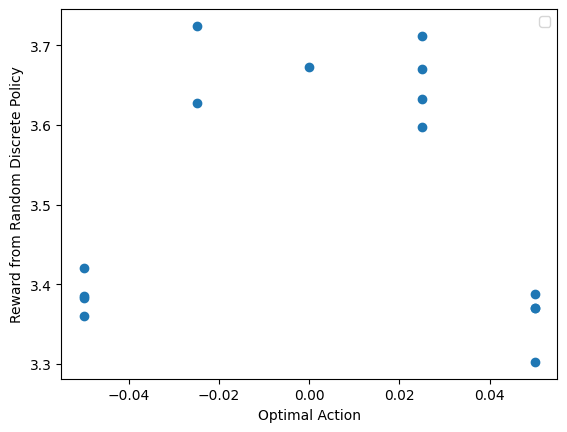

In [68]:
obs_arr = np.array(obs_list).reshape(-1)
# weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -0.05 * obs_arr # -np.sum(weighted_obs_arr, axis=-1)

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [69]:
print(obs_list)

[array([-1.]), array([1.]), array([-1.]), array([-0.5]), array([-1.]), array([0.5]), array([-0.5]), array([1.]), array([1.]), array([-0.5]), array([0.5]), array([0.]), array([-1.]), array([-0.5]), array([1.])]


In [70]:
action_arr = np.array(action_list)

relevant_actions = action_arr[:, [0, 3]]

print(relevant_actions)

[[-0.02492595 -0.00206194]
 [-0.6028878  -0.00594365]
 [-0.02417542 -0.00182577]
 [-0.16478065 -0.00225453]
 [-0.02761839 -0.00409799]
 [-0.48177347 -0.00387265]
 [-0.1599312  -0.00357964]
 [-0.609231   -0.0044822 ]
 [-0.6067001  -0.00550737]
 [-0.16035876 -0.0040371 ]
 [-0.47081175 -0.00574866]
 [-0.3244211  -0.00233644]
 [-0.02090953 -0.00202479]
 [-0.16729413 -0.00485042]
 [-0.60543203 -0.00252226]]


In [77]:
optimal_actions = -(obs_arr.reshape(-1) + 1) * 0.5 * np.pi * 0.05 / 0.25

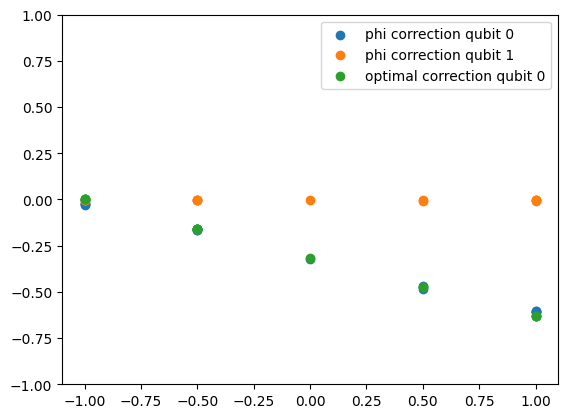

In [78]:
plt.scatter(obs_arr.reshape(-1), np.clip(relevant_actions[:,0], a_min=-1., a_max=1.), label='phi correction qubit 0')
plt.scatter(obs_arr.reshape(-1), np.clip(relevant_actions[:,1], a_min=-1., a_max=1.), label='phi correction qubit 1')
plt.scatter(obs_arr.reshape(-1), optimal_actions, label='optimal correction qubit 0')
plt.legend()
plt.ylim(-1, 1)
plt.show()